In [32]:
# Importing the libraries

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Setting the parameters
vocabSize = 10000
maxLen = 200

In [34]:
# Detect encoding and read dataset
import chardet
with open('imdb_master.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))

df = pd.read_csv('imdb_master.csv', encoding=result['encoding'])

In [35]:
# Clean the data
df = df.drop(columns=['Unnamed: 0', 'type', 'file'])
df = df[df['label'].isin(['pos', 'neg'])]
df['label'] = df['label'].map({'pos': 1, 'neg': 0}).astype(int)

In [36]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [37]:
# Tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocabSize, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [38]:
# Padding
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq, maxlen=maxLen, padding='post')
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_seq, maxlen=maxLen, padding='post')

In [39]:
# Build the improved model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocabSize, output_dim=128, input_length=maxLen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout to reduce overfitting
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [40]:
# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# Add EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [42]:
# Train
history = model.fit(
    x_train_pad, y_train,
    batch_size=128,
    epochs=10,  # can stop early due to EarlyStopping
    validation_data=(x_test_pad, y_test),
    callbacks=[early_stop]
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.7078 - loss: 0.5222 - val_accuracy: 0.8744 - val_loss: 0.2956
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9528 - loss: 0.1348 - val_accuracy: 0.8649 - val_loss: 0.3765
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9952 - loss: 0.0204 - val_accuracy: 0.8610 - val_loss: 0.4995
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.9993 - loss: 0.0051 - val_accuracy: 0.8654 - val_loss: 0.5689


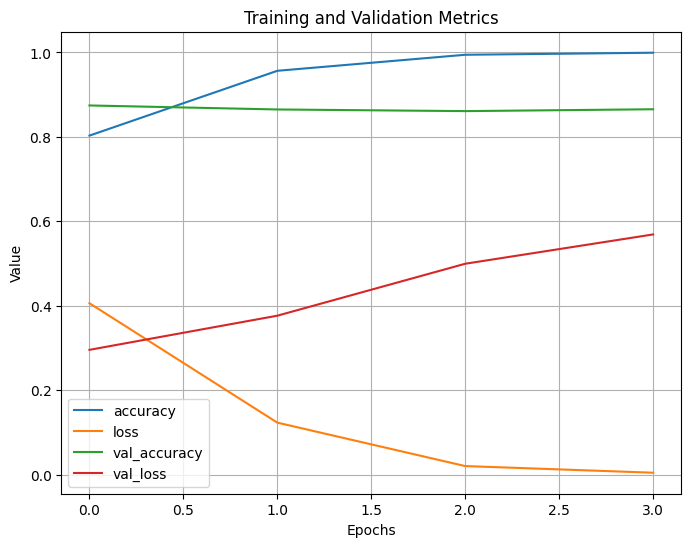

In [43]:
# Plot accuracy and loss
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [44]:
# Evaluate on test data
loss, accuracy = model.evaluate(x_test_pad, y_test)
print(f"Test Accuracy: {100 * accuracy:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8797 - loss: 0.2881
Test Accuracy: 87.44%


In [45]:
# Predictions
y_pred = model.predict(x_test_pad).flatten()
y_pred = (y_pred > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


              precision    recall  f1-score   support

           0       0.88      0.87      0.88      5055
           1       0.87      0.88      0.87      4945

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



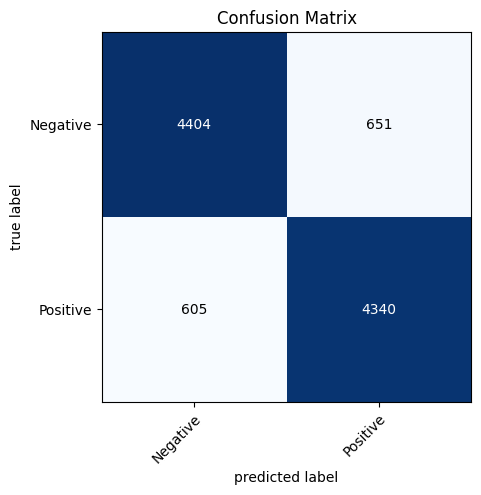

In [46]:
# Report and Confusion Matrix
print(metrics.classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.show()

| Metric    | Class 0 (Negative) | Class 1 (Positive) | Comments                                                            |
| --------- | ------------------ | ------------------ | ------------------------------------------------------------------- |
| Precision | 91%                | 84%                | Model is more confident when labeling "negative" reviews correctly. |
| Recall    | 83%                | 92%                | Model catches more positive reviews than negative ones.             |
| F1-Score  | 87%                | 88%                | Balanced F1 indicates good performance across both classes.         |


True Positives (4526): Positive reviews correctly classified.

True Negatives (4182): Negative reviews correctly classified.

False Positives (873): Negative reviews misclassified as positive.

False Negatives (419): Positive reviews misclassified as negative.